In [19]:
from torch import nn
import torch
from torchsummary import summary
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
])

In [22]:
def load_images(path):
    data_list = list()
    for filename in os.listdir(path):
        img = Image.open(os.path.join(path, filename))
        img = transform(img)
        sat_img, map_img = img[:, :, :256], img[:, :, 256:]
        data_list.append((sat_img, map_img))
    return data_list

In [23]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, path):
        self.data = load_images(path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dataset = CustomDataset("data/maps/train/")

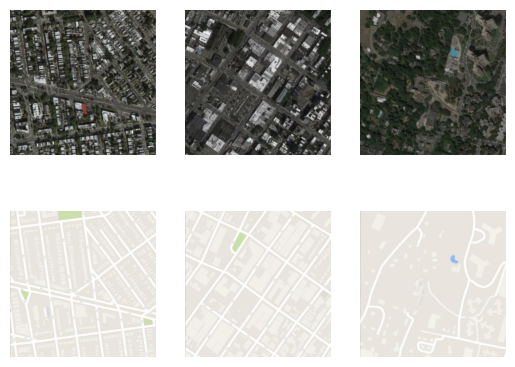

In [24]:
n_samples = 3
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis("off")
    plt.imshow((dataset[i][0].permute(1, 2, 0)+1)/2)
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis("off")
    plt.imshow((dataset[i][1].permute(1, 2, 0)+1)/2)

In [25]:
EPOCH_NUM = 100
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [26]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv')!=-1 or classname.find('Linear')!=-1:
    nn.init.normal_(m.weight.data,0.0,0.02)
  elif classname.find('BatchNorm')!=-1:
    nn.init.normal_(m.weight.data,1.0,0.02)
    nn.init.constant_(m.bias.data,0)

In [27]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(6, 64, 4, 2, padding=1)
        self.lrelu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        #LeakyReLU
        self.conv3 = nn.Conv2d(128, 256, 4, 2, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        #LeakyReLU
        self.conv4 = nn.Conv2d(256, 512, 4, 2, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        #LeakyReLU
        self.conv5 = nn.Conv2d(512, 512, 4, padding='same')
        self.bn4 = nn.BatchNorm2d(512)
        #LeakyReLU
        self.conv6 = nn.Conv2d(512, 1, 4, padding='same')
        self.sigmoid = nn.Sigmoid()
        self.last = nn.Sequential(nn.Flatten(), nn.LazyLinear(1))
    
    def forward(self, x1, x2 = torch.zeros((2, 3, 256, 256), device=device)):
        x = torch.concatenate((x1, x2), dim=1)
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.bn1(self.conv2(x)))
        x = self.lrelu(self.bn2(self.conv3(x)))
        x = self.lrelu(self.bn3(self.conv4(x)))
        x = self.lrelu(self.bn4(self.conv5(x)))
        x = self.sigmoid(self.last(self.conv6(x)))
        return x

In [28]:
netD = Discriminator().to(device)
netD.apply(weights_init)

summary(netD, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           6,208
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,664
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12          [-1, 512, 16, 16]       4,194,816
      BatchNorm2d-13          [-1, 512, 16, 16]           1,024
        LeakyReLU-14          [-1, 512,

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [29]:
def EncodBlock(d_input, d_output, batch_norm=True):
    layers = [
        nn.Conv2d(d_input, d_output, 4, 2, padding=1),
        nn.LeakyReLU(0.2)
    ]
    if batch_norm:
        layers.insert(1, nn.BatchNorm2d(d_output))
    block = nn.Sequential(*layers)
    return block

In [30]:
class DecodBlock(nn.Module):
    def __init__(self, d_input, d_output, drop=True) -> None:
        super().__init__()
        self.drop = drop
        self.convt1 = nn.ConvTranspose2d(d_input, d_output, 4, 2, padding=1)
        self.bn1 = nn.BatchNorm2d(d_output)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
    def forward(self, x1, x2):
        x1 = self.bn1(self.convt1(x1))
        if self.drop:
            x1 = self.dropout(x1)
        x = torch.concatenate((x1, x2), dim=1)
        x = self.relu(x)
        return x

In [31]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.e1 = EncodBlock(3, 64, False)
        self.e2 = EncodBlock(64, 128)
        self.e3 = EncodBlock(128, 256)
        self.e4 = EncodBlock(256, 512)
        self.e5 = EncodBlock(512, 512)
        self.e6 = EncodBlock(512, 512)
        self.e7 = EncodBlock(512, 512)
        
        self.b1 = nn.Conv2d(512, 512, 4, 2, padding=1)
        self.relu = nn.ReLU()
        
        self.d1 = DecodBlock(512, 512)
        self.d2 = DecodBlock(1024, 512)
        self.d3 = DecodBlock(1024, 512)
        self.d4 = DecodBlock(1024, 512, False)
        self.d5 = DecodBlock(1024, 256, False)
        self.d6 = DecodBlock(512, 128, False)
        self.d7 = DecodBlock(256, 64, False)
        
        self.o1 = nn.ConvTranspose2d(128, 3, 4, 2, padding=1)
        self.tanh = nn.Tanh()
    
    def forward(self, x1):
        e1 = self.e1(x1)
        e2 = self.e2(e1)
        e3 = self.e3(e2)
        e4 = self.e4(e3)
        e5 = self.e5(e4)
        e6 = self.e6(e5)
        e7 = self.e7(e6)
        b1 = self.relu(self.b1(e7))
        d1 = self.d1(b1, e7)
        d2 = self.d2(d1, e6)
        d3 = self.d3(d2, e5)
        d4 = self.d4(d3, e4)
        d5 = self.d5(d4, e3)
        d6 = self.d6(d5, e2)
        d7 = self.d7(d6, e1)
        out = self.tanh(self.o1(d7))
        return out

In [32]:
netG = Generator().to(device)

summary(netG, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,664
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12            [-1, 512, 8, 8]       4,194,816
      BatchNorm2d-13            [-1, 512, 8, 8]           1,024
        LeakyReLU-14            [-1, 51

In [33]:
criterion_D = nn.BCELoss()
criterion_L = nn.L1Loss()

D_optimizer = optim.Adam(netD.parameters(), lr=2e-4, betas=(0.5, 0.999))
G_optimizer = optim.Adam(netG.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [34]:
def save_image(img_list, epoch):
    plt.figure(figsize=(16, 16));
    plt.axis("off")
    plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
    if not os.path.exists('generated'):
        os.makedirs('generated')
    plt.savefig("generated/img%d.png" % epoch, bbox_inches='tight', pad_inches=0)

In [ ]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import torchvision.utils as vutils

img_list = []

now = datetime.now()
timestamp = now.strftime("%Y%m%d-%H%M%S")
logdir = f"trainings/{timestamp}/"
writer = SummaryWriter(logdir)
global_step = 0

for ep in range(EPOCH_NUM):
  torch.cuda.empty_cache()
  batch_iterator = tqdm(dataloader, desc=f"Processing Epoch {ep+1:02d}")
  for i, (target, data) in enumerate(batch_iterator):
    b_size = data.shape[0]

    data = data.to(device)
    target = target.to(device)
    real_labels = torch.ones((b_size, 1), requires_grad=False).to(device)
    fake_labels = torch.zeros((b_size, 1), requires_grad=False).to(device)

    netD.zero_grad()
    real_d = netD(data, target)
    loss_D_real = criterion_D(real_d, real_labels)  
    
    fake_images = netG(data)
    fake_d = netD(fake_images.detach(), target)
    loss_D_fake = criterion_D(fake_d, fake_labels)
    
    loss_D = (loss_D_real + loss_D_fake) / 2
    loss_D.backward(retain_graph=True)

    netG.zero_grad()
    criterion_L.zero_grad()
    fake_d = netD(fake_images, target)
    loss_G = criterion_L(fake_d, real_labels)
    loss_G.backward(retain_graph=True)
    
    D_optimizer.step()
    G_optimizer.step()
    
    writer.add_scalars('losses', {'DLoss': loss_D.item(), 'GLoss': loss_G.item()}, global_step)
    writer.flush()
    global_step += 1
    if i % 500 == 0:
      with torch.no_grad():
        fake = netG(data).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
  if ep % 2 == 0:
    save_image(img_list, ep+1)